In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer

csv_path = 'https://raw.githubusercontent.com/DyanielCX/DLI-Assm/refs/heads/main/dataset_B_05_2020_1.csv'
df = pd.read_csv(csv_path)

text_col_candidates = [c for c in df.columns if c.lower() in ['url','text','content','message','body','title'] or 'url' in c.lower()]
label_col_candidates = [c for c in df.columns if c.lower() in ['label','status','target','class','category','phishing']]

if not text_col_candidates or not label_col_candidates:
    raise ValueError(f"Could not infer columns. Columns found: {df.columns.tolist()}")

text_col = text_col_candidates[0]
label_col = label_col_candidates[0]

X_text = df[text_col].astype(str).fillna('')
y_raw = df[label_col].astype(str).fillna('')

X_train_text, X_temp_text, y_train_raw, y_temp_raw = train_test_split(X_text, y_raw, test_size=0.3, random_state=42, stratify=y_raw)
X_val_text, X_test_text, y_val_raw, y_test_raw = train_test_split(X_temp_text, y_temp_raw, test_size=0.5, random_state=42, stratify=y_temp_raw)

tokenizer = Tokenizer(lower=True, char_level=True, oov_token='-n-')
tokenizer.fit_on_texts(pd.concat([X_train_text, X_val_text, X_test_text], axis=0))

X_train = tokenizer.texts_to_sequences(list(X_train_text))
X_val = tokenizer.texts_to_sequences(list(X_val_text))
X_test = tokenizer.texts_to_sequences(list(X_test_text))

encoder = LabelEncoder()
encoder.fit(sorted(y_raw.unique()))
y_train = to_categorical(encoder.transform(y_train_raw))
y_val = to_categorical(encoder.transform(y_val_raw))
y_test = to_categorical(encoder.transform(y_test_raw))

epochs = 15
batch_size = 32
sequence_length = 300
embed_dim = 100

print(f'Using text column: {text_col}')
print(f'Using label column: {label_col}')
print('Data ready.')


Using text column: url
Using label column: status
Data ready.


In [21]:
# CNN model definition (parallel CNN with multiple kernel sizes)
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dense, Dropout

def build_cnn_parallel(vocab_size, embed_dim=50, sequence_length=200, num_classes=2):
    """
    CNN with parallel Conv1D layers of different kernel sizes (3, 5, 7).
    Embedding -> [Conv3, Conv5, Conv7] -> Concatenate -> Dense(cnn_features) -> Dropout -> Output
    """
    inputs = Input(shape=(sequence_length,))
    x = Embedding(vocab_size + 1, embed_dim)(inputs)

    convs = []
    for k in [3, 5, 7]:
        c = Conv1D(filters=128, kernel_size=k, activation="relu", padding="same")(x)
        p = GlobalMaxPooling1D()(c)
        convs.append(p)

    x = Concatenate()(convs)

    # Named feature layer
    x = Dense(128, activation="relu", name="cnn_features")(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [23]:
# Compile and train CNN
from keras.preprocessing import sequence
from sklearn.metrics import classification_report, confusion_matrix
import time

sequence_length = 200 if 'sequence_length' not in globals() else sequence_length
x_train_pad = sequence.pad_sequences(X_train, maxlen=sequence_length)
x_val_pad = sequence.pad_sequences(X_val, maxlen=sequence_length)
x_test_pad = sequence.pad_sequences(X_test, maxlen=sequence_length)

vocab_size = len(tokenizer.word_index)
num_classes = y_train.shape[1]
embed_dim = 50 if 'embed_dim' not in globals() else embed_dim

cnn_model = build_cnn_parallel(vocab_size, embed_dim, sequence_length, num_classes)
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

start_time = time.time()
history = cnn_model.fit(
    x_train_pad, y_train,
    validation_data=(x_val_pad, y_val),
    epochs=epochs if 'epochs' in globals() else 10,
    batch_size=batch_size if 'batch_size' in globals() else 128,
    shuffle=True,
    verbose=1
)
train_time = time.time() - start_time

test_loss, test_acc = cnn_model.evaluate(x_test_pad, y_test, verbose=0)

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(cnn_model.predict(x_test_pad, verbose=0), axis=1)
report = classification_report(y_true, y_pred, digits=4)
cm = confusion_matrix(y_true, y_pred)

print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(report)


Epoch 1/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.7242 - loss: 0.5327 - val_accuracy: 0.8862 - val_loss: 0.3037
Epoch 2/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8878 - loss: 0.2773 - val_accuracy: 0.8973 - val_loss: 0.2494
Epoch 3/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9338 - loss: 0.1751 - val_accuracy: 0.9347 - val_loss: 0.1792
Epoch 4/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9568 - loss: 0.1244 - val_accuracy: 0.9300 - val_loss: 0.1742
Epoch 5/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9681 - loss: 0.0838 - val_accuracy: 0.8979 - val_loss: 0.2641
Epoch 6/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9892 - loss: 0.0433 - val_accuracy: 0.9294 - val_loss: 0.2059
Epoch 7/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9945 - loss: 0.0240 - val_accuracy: 0.9312 - val_loss: 0.2163
Epoch 8/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9913 - loss: 0.0241 - val_accuracy:

In [24]:
# Build [cnn_features | scaled_tabular] for ALL rows, then split for SVC
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1) Extract CNN penultimate features for all samples
X_all_seq = tokenizer.texts_to_sequences(list(X_text))
X_all_pad = pad_sequences(X_all_seq, maxlen=sequence_length)

feature_extractor = Model(
    inputs=cnn_model.input,
    outputs=cnn_model.get_layer("cnn_features").output
)
cnn_feats_all = feature_extractor.predict(X_all_pad, verbose=0)

# 2) Tabular features = everything except the text and label columns
ml_features = df.drop(columns=[text_col, label_col]).copy()

# If there are no extra columns, fall back to only CNN features
if ml_features.shape[1] == 0:
    X_combined = cnn_feats_all
else:
    scaler = StandardScaler()
    ml_scaled = scaler.fit_transform(ml_features.values)
    X_combined = np.hstack([cnn_feats_all, ml_scaled])

# Integer labels for sklearn models
y_all = encoder.transform(y_raw)

print("cnn_feats_all:", cnn_feats_all.shape,
      "| tabular:", (ml_features.shape[0], ml_features.shape[1]),
      "| X_combined:", X_combined.shape)


cnn_feats_all: (11430, 128) | tabular: (11430, 87) | X_combined: (11430, 215)


LinearSVC on [cnn_features | tabular] — test accuracy: 0.9580
Classification report:
               precision    recall  f1-score   support

           0     0.9532    0.9633    0.9582      1143
           1     0.9629    0.9528    0.9578      1143

    accuracy                         0.9580      2286
   macro avg     0.9581    0.9580    0.9580      2286
weighted avg     0.9581    0.9580    0.9580      2286



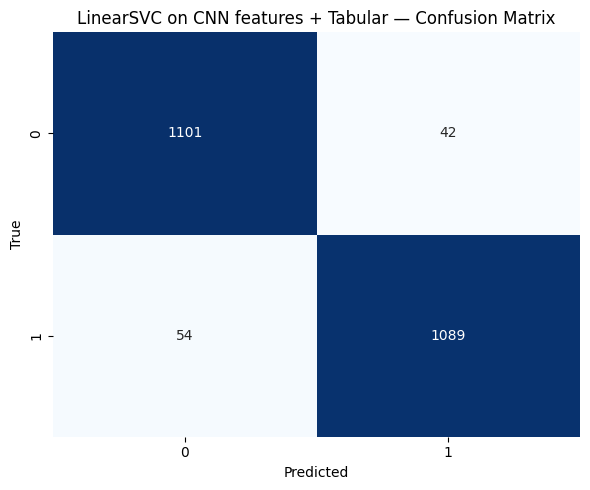

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(
    X_combined, y_all, test_size=0.2, stratify=y_all, random_state=42
)

svm_model = LinearSVC(
    loss="squared_hinge",
    penalty="l2",
    dual=True,
    class_weight="balanced",
    C=1.0,
    tol=1e-3,
    max_iter=100000,
    random_state=42
)
svm_model.fit(X_train_svc, y_train_svc)

y_pred_svc = svm_model.predict(X_test_svc)
svc_acc = accuracy_score(y_test_svc, y_pred_svc)
print(f"LinearSVC on [cnn_features | tabular] — test accuracy: {svc_acc:.4f}")
print("Classification report:\n", classification_report(y_test_svc, y_pred_svc, digits=4))

cm = confusion_matrix(y_test_svc, y_pred_svc)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("LinearSVC on CNN features + Tabular — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
